# Simple example of integrating the Rubidium wavefunction

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from numerov.rydberg import RydbergState

logging.basicConfig(level=logging.INFO, format="%(levelname)s %(filename)s: %(message)s")
logging.getLogger("numerov").setLevel(logging.WARNING)

In [2]:
dn, dl, dj, dm = (0, 0, 0, 0)
qn_list = np.array([(n + dn, n - 1 + dl, n - 0.5 + dj) for n in range(20, 150)])

In [3]:
def get_zmin(state: RydbergState) -> dict[str, float]:
    zmin = {
        r"z(V_{hydrogen}=E_{hydrogen})": state.calc_hydrogen_z_turning_point(),
        "z(V=E)": state.calc_z_turning_point(),
        "z_cutoff": state.z_cutoff,
        "used zmin": state.grid.zmin,
        "z(V=0)": state.calc_z_V_eq_0(),
    }
    return zmin

In [4]:
zmin_list = []
for qn in qn_list:
    print(f"n={qn[0]}", end="\r")
    state = RydbergState("Rb", qn[0], qn[1], qn[2])
    state.create_grid(dz=0.001)
    state.integrate()
    zmin = get_zmin(state)
    zmin_list.append(zmin)

zmin_dict = {key: [zmin[key] for zmin in zmin_list] for key in zmin_list[0].keys()}

WARNING rydberg.py: xmin=173.369889 was not chosen good (sum_small_z=0.001297280021569471), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=193.87777599999998 was not chosen good (sum_small_z=0.0011822453525580606), and the wavefunction is positive at the inner boundary, so we could not fix it.
WARNING rydberg.py: xmin=215.590489 was not chosen good (sum_small_z=0.0010751104102643108), and the wavefunction is positive at the inner boundary, so we could not fix it.


In [5]:
import arc

atom = arc.Rubidium87()

arc_zmin = []
for qn in qn_list:
    print(f"n={qn[0]}", end="\r")
    n, l, j = qn
    r, psi_r = atom.radialWavefunction(
        int(l),
        0.5,
        j,
        atom.getEnergy(n, l, j) / 27.211,
        atom.alphaC ** (1 / 3.0),
        2.0 * n * (n + 15.0),
        step=0.001,
        n=n,
    )
    arg_rmin = np.argwhere(psi_r != 0).flatten()[0]
    rmin = r[arg_rmin]
    zmin = np.sqrt(rmin)
    arc_zmin.append(zmin)

zmin_dict["ARC z_cutoff"] = arc_zmin

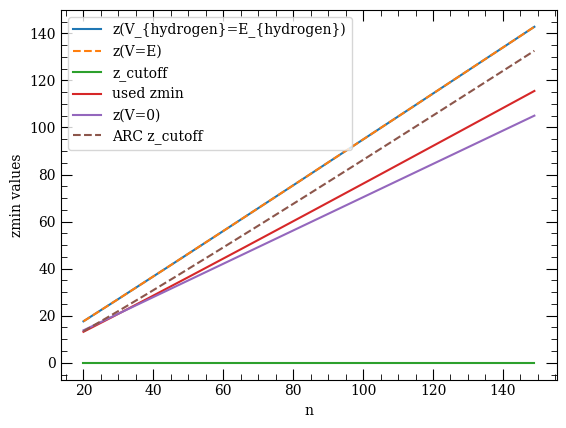

In [6]:
n_list = qn_list[:, 0]
fig, ax = plt.subplots()

ls_dict = {
    "z(V=E)": "--",
    "ARC z_cutoff": "--",
}

for key, values in zmin_dict.items():
    ax.plot(n_list, values, ls=ls_dict.get(key, "-"), label=key)

ax.set_xlabel("n")
ax.set_ylabel("zmin values")

ax.legend()
plt.show()